## Chạy proj trên ubuntu <br>

Cài đặt wsl bằng cmd : `wsl --install -d Ubuntu` <br>
Nâng cấp Ubuntu từ WSL 1 lên WSL 2 : </br>
`wsl --set-version Ubuntu 2` <br>
Kiểm tra phiên bản WSL bằng lệnh:  `wsl -l -v` (wsl --list --verbose) </br>
Đặt WSL 2 làm phiên bản mặc định cho các bản phân phối Linux mớ : ` wsl --set-default-version 2` </br>
Cài đặt extension Remote explore cho VSC </br>
Vào folder /home/TuanKiet của ubuntu , chạy git bash `git clone https://github.com/ntp2003/chatbot-tlcn`  <br>
Mở Remote explore trên VSC mở  tới /home/TuanKiet/chatbot-tlcn </br>

Update apt và cài đặt pip : `sudo apt update && sudo apt upgrade -y` </br>
`sudo apt install python3-pip -y` </br>

### Tạo môi trường ảo với Python 3

`sudo apt install python3.12-venv -y` 

`python3 -m venv .venv`

Kích hoạt môi trường ảo
- Windows: .venv\Scripts\activate
- Linux/Mac : `source .venv/bin/activate`

### Cài đặt dependencies từ pyproject.toml
#### Cài đặt Poetry  trong venv
- Window : `pip install poetry`
- Linux/macOS : `curl -sSL https://install.python-poetry.org | python3 -`

Thêm Poetry vào PATH nếu cần : `export PATH="$HOME/.local/bin:$PATH"`

#### Cài đặt môi trường dự án
Di chuyển vào thư mục chứa pyproject.toml, chạy: `poetry install`

### Kích hoạt môi trường ảo của Poetry
`poetry shell`

Sau khi bật docker image db và upgrade migration 

Khởi chạy app.py : $ chainlit run app.py -w 


Database : Postgresql với file docker-compse.yml , Alembic

- Khởi động : `docker-compose up -d` </br>
    Tự động load .env trong cùng root dir </br>
- Chạy các migrations chưa được áp dụng, đưa db lên phiên bản mới nhất: </br>
    `alembic upgrade head` </br>
- Dừng services : docker-compose down

- Tham khảo viết docker-compose.yml
    - Docker Compose file reference: https://docs.docker.com/compose/compose-file/
    - PostgreSQL configuration: https://www.postgresql.org/docs/current/runtime-config.html
    - Redis configuration: https://redis.io/topics/config

### Vị trí lưu file
Toàn bộ hệ thống file của WSL, bao gồm cả /home/TuanKiet/, được lưu trong file ảo </br> 
`C:\Users\TuanKiet\AppData\Local\Packages\CanonicalGroupLimited.Ubuntu_79rhkp1fndgsc\LocalState\ext4.vhdx` </br>

Các gói Python được cài vào:
`/usr/lib/python3/dist-packages/` </br>
Gói cài bằng pip (cho toàn hệ thống):
`/usr/local/lib/python3.*/dist-packages/` </br>
Gói cài bằng pip (cho user, nếu dùng pip install --user):
`/home/TuanKiet/.local/lib/python3.*/site-packages/` </br>

## Crawl data from fptshop.com.vn

Truy cập fptshop.com.vn và chọn danh mục như Laptop hay điện thoại 

VD với điện thoại :

Sau khi chọn danh mục điện thoại tới url `https://fptshop.com.vn/dien-thoai`

Mở devtool chọn Network -> bật filter `Fetch/XHR (XMLHttpRequest)`. Đây là các AJAX request (hoặc API request) mà trang web gửi đi khi tải dữ liệu.

Tìm POST request liên quan đến sản phẩm (ở đây là `category`)

Để chắc chắn click vào request mở phần Preview để xem data 

Lấy các thông tin cần thiết cho việc crawl ở phần Headers:
- request URL - chính là post_url cần truyền vào
- request headr

        





Kiến trúc : </br>

- Tầng model :
    Định nghĩa cấu trúc dữ liệu và tương tác db thông qua ORM (Object-Relational Mapping)- SQLAlchemy.

    2 loại model:
    - class Phone(Base) : SQLAlchemy model - interact directly with db
    - class PhoneModel(BaseModel): Pydantic model to Validate n Serialize (convert object/data into stored or transmitted such as JSON,XML,binary stream) /Deserialze data 
    

- Tầng repositories : Các hàm thao tác với data 
    Xử lý thao tác CRUD với db
    Method để truy vấn data
    Quản lý transaction và session db

Service layer (store_chatbot.py , openai) -> Repository layer (phone.py, brand.py) -> Model layer (Phone , Brand, FAQ..) -> DB


trong app.py : </br>
Khởi tạo:
- LiteralClient : Monitor OpenAI API calls , log các API calls vào hệ thống
- Redis Worker: Khởi động  Redis queue worker với scheduler để xử lý các tác vụ bất đồng bộ và hàng đợi
- Database Migration: Alembic chạy các migrations , đảm bảo schema database được cập nhật

Các module cần thiết: </br>
- `chainlit_process.authentication`: xử lý xác thực người dùng
- `chainlit_process.message`: xử lý tin nhắn chat 

User gửi message lên UI => Chainlit trigger decorator `@cl.on_message` trong `chainlit_process.message.py` : </br>
Hàm `main()` trong `message.py` được gọi -> `gen_answer()` trong `service.store_chatbot.py` được gọi để sinh response gửi đến UI qua send() -> gọi `gen_openai_answer()` aka `gen_answer()` trong `service.openai.py` được gọi sinh trả lời.

`gen_answer()` trong service.store_chatbot.py :
- Khởi tạo messages với system prompt
- Format các history message trên Chainlit UI vào formatted_messages để gửi đến OpenAI API
- Thêm các instruction prompt như constraint, workflow, initialization vào formatted_messages
- Gọi đến gen_openai_answer() hay gen_answer() trong service.openai.py để sinh response với formatted_messages và các defined tools : faq_tool, collect_requirement_tool, search_phone_database_tool, collect_user_contact_info_tool
- Trả về Message object với content là response_text từ gen_openai_answer() hay gen_answer() trong service.openai.py

`gen_openai_answer()` hay gen_answer() trong service.openai.py :
- Gọi đến OpenAI API với messages, tools, model, temperature, timeout
- OpenAI sẽ trả về response với tool_calls nếu có
    - Nếu không có tool_calls hay tool_choices trả về response.content và temporary_memory và kết thúc
    - Nếu có tool_calls hay tool_choices và counter < max_iterator = 5 :
        - append model's function call message's copy vào messages
        - Gọi đến invoke_tool.py để exec tool và truyền vào tool_response content
        - append tool_response là 1 ChatCompletionToolMessageParam vào messages
        - Gọi đến OpenAI API với messages, tools, model, temperature, timeout
        - OpenAI sẽ trả về response với tool_calls nếu có
        - counter += 1

chatbot giả lập bán hàng dùng dữ liệu từ fptshop.vn. Chatbot có khả năng trả lời các câu hỏi về FAQ và thông tin điện thoại từ người dùng, với dữ liệu được lưu trữ trong PostgreSQL container (docker).

## Kiến trúc tổng quan

Ứng dụng được tổ chức theo mô hình repository pattern với các thành phần chính:

- Giao diện người dùng: Xây dựng bằng Chainlit

- Cơ sở dữ liệu: 
    - PostgreSQL (trong container Docker):
        - Chứa thông tin về sản phẩm điện thoại (phones), FAQ (faqs), thương hiệu (brands), và thông tin người dùng (users).
        - Dữ liệu được truy vấn thông qua SQLAlchemy ORM.
    - Redis:
        - Lưu trữ tạm thời số trang (paging) khi truy vấn điện thoại vào cache, giúp quản lý phân trang và trạng thái cuộc trò chuyện.
    - Alembic:
        - Đảm bảo quản lý phiên bản của cơ sở dữ liệu.


- Xử lý ngôn ngữ tự nhiên: Sử dụng OpenAI API


## Quy trình hoạt động

1. Khởi động ứng dụng:

- File app.py là điểm vào của ứng dụng, được chạy bằng lệnh chainlit run app.py -w

- Khi khởi động, ứng dụng chạy migration với Alembic để cập nhật cấu trúc database

- Khởi tạo Redis worker để xử lý các tác vụ bất đồng bộ

2. Xác thực người dùng:

Người dùng đăng nhập qua giao diện Chainlit

Hàm `auth_callback` trong `chainlit_process/authentication.py` xử lý xác thực

Thông tin người dùng được kiểm tra trong database

3. Xử lý tin nhắn:

Khi người dùng gửi tin nhắn, hàm main trong `chainlit_process/message.py` được gọi

Tin nhắn được chuyển đến `service/store_chatbot.py` để xử lý

4. Tạo phản hồi:

Hàm `gen_answer` trong `service/store_chatbot.py` xử lý tin nhắn từ người dùng

Các prompt hệ thống được thêm vào để định hình vai trò và hành vi của chatbot

Tin nhắn được gửi đến OpenAI API thông qua `service/openai.py`

5. Sử dụng công cụ (tools):

Chatbot dùng các tools để thực hiện các tác vụ cụ thể:

`collect_requirement_tool`: Thu thập yêu cầu của người dùng

`search_phone_database_tool`: Tìm kiếm thông tin điện thoại

`faq_tool`: Trả lời câu hỏi thường gặp

`collect_user_contact_info_tool`: Thu thập thông tin liên hệ

6. Lưu trữ bộ nhớ người dùng:

Thông tin về nhu cầu, sở thích và yêu cầu của người dùng được lưu trong user_memory

Dữ liệu này được sử dụng để cá nhân hóa trải nghiệm và đưa ra gợi ý phù hợp

7. Tìm kiếm thông tin điện thoại:

Sử dụng vector embedding để tìm kiếm ngữ nghĩa

Hỗ trợ tìm kiếm theo tên, thương hiệu, khoảng giá

8. Trả lời câu hỏi thường gặp:

Sử dụng vector embedding để tìm câu hỏi tương tự trong cơ sở dữ liệu FAQ

Trả về câu trả lời phù hợp nhất

### Các thành phần chính
#### Models - define data structure
`User`: Lưu trữ thông tin người dùng

`UserMemory`: Lưu trữ thông tin về nhu cầu và sở thích của người dùng

`Phone`: Lưu trữ thông tin về điện thoại

`Laptop`: Lưu trữ thông tin về Laptop

`Brand`: Lưu trữ thông tin về thương hiệu

`FAQ`: Lưu trữ câu hỏi thường gặp và câu trả lời

#### Repositories
Các repository chịu trách nhiệm tương tác với cơ sở dữ liệu:

`user.py`: Quản lý người dùng

`user_memory.py`: Quản lý bộ nhớ người dùng

`phone.py`: Quản lý thông tin điện thoại

`brand.py`: Quản lý thương hiệu

`faq.py`: Quản lý FAQ

#### Services
`openai.py`: Tương tác với OpenAI API

`embedding.py`: Tạo vector embedding

`store_chatbot.py`: Xử lý tin nhắn và tạo phản hồi

`converter.py`: Chuyển đổi dữ liệu

`email.py`: Gửi email

#### Tools
Các công cụ được sử dụng bởi chatbot:

- `collect_requirement.py`: Thu thập yêu cầu của người dùng

- `search_phone_database.py`: Tìm kiếm thông tin điện thoại

- `faq.py`: Trả lời câu hỏi thường gặp

- `collect_user_contact_info.py`: Thu thập thông tin liên hệ

- `invoke_tool.py`: Gọi các công cụ khác

#### Quy trình xử lý tin nhắn chi tiết
1. Người dùng gửi tin nhắn qua giao diện Chainlit

2. Tin nhắn được chuyển đến hàm main trong chainlit_process/message.py

3. Hàm `gen_answer` trong `service/store_chatbot.py` được gọi với ID người dùng, ID cuộc trò chuyện và lịch sử tin nhắn

4. Các prompt system định hình vai trò và hành vi của chatbot

5. Tin nhắn được gửi đến OpenAI API thông qua service/openai.py

6. OpenAI API trả về phản hồi hoặc yêu cầu sử dụng công cụ

7. Nếu cần dùng function call tool, `invoke_tool` được gọi để thực hiện tác vụ

Kết quả từ công cụ được gửi lại cho OpenAI API để tạo phản hồi cuối cùng

Phản hồi cuối cùng được gửi lại cho người dùng qua giao diện Chainlit

Client Request 
-> Service (Business Logic) #implement business logic
-> Repository (Data Access) # xử lý tương tác database
-> Model (Data Structure) #định nghĩa cấu trúc data
-> Database

Tích hợp chatbot vào messenger
- Step 1: Create FB Page , FB app, config webhook
    - Create a FB Page
    - Create a FB App
    - Deploy webhook to server (like Heroku,EC2..) hoặc create public link via ngrok

- Step 2: Embed the Fb Messenger
- Step 3: Use Fb Messenger bot with WitAI
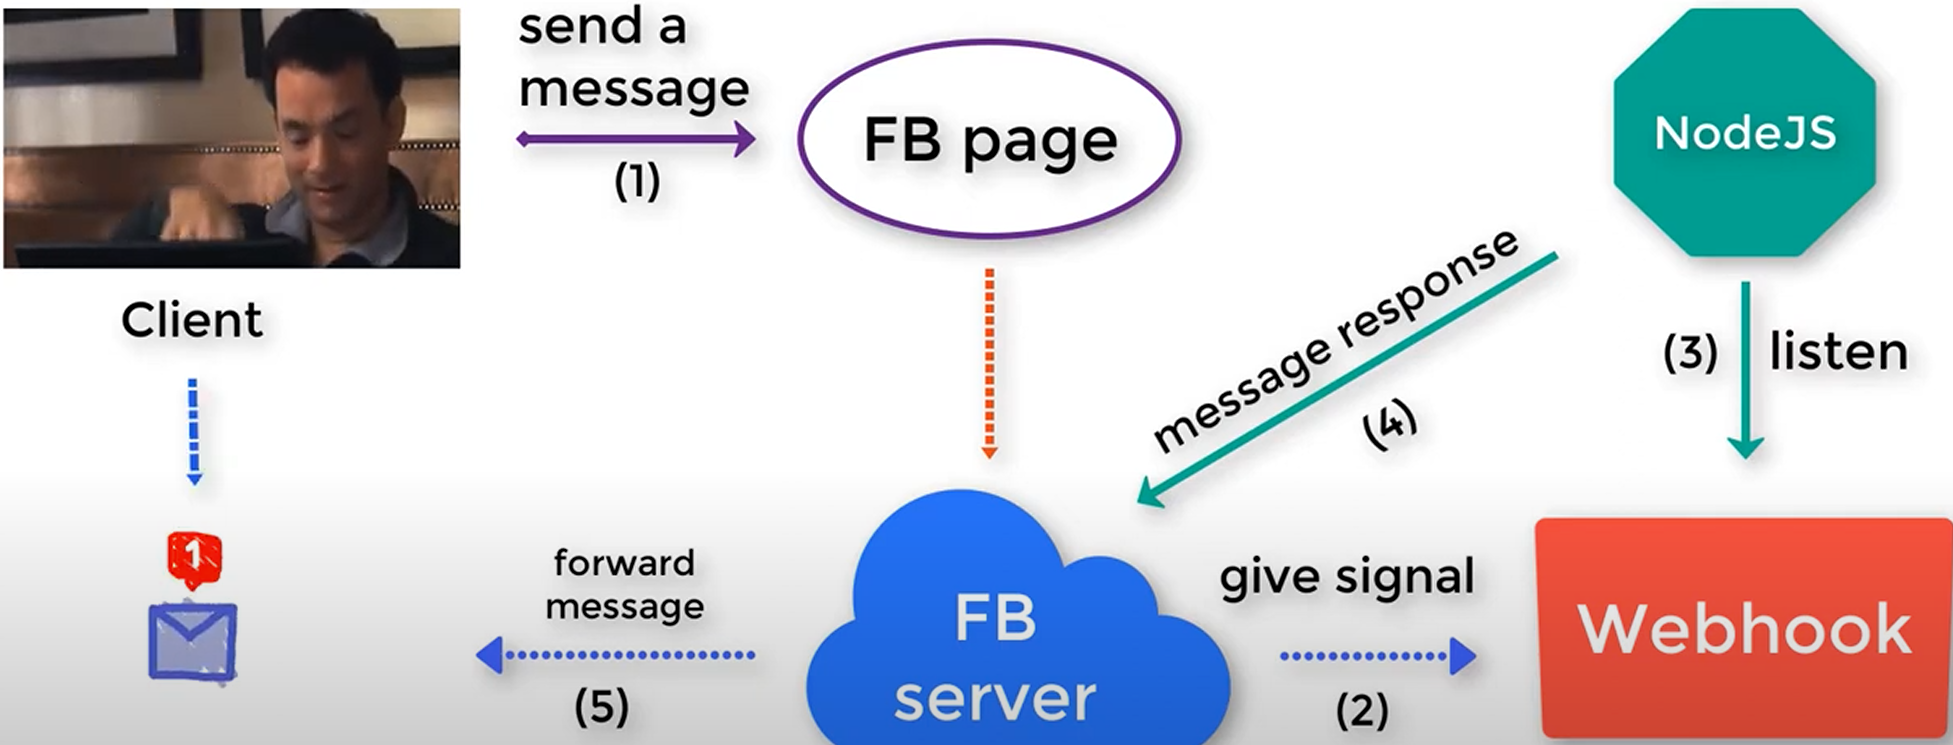

Responsiveness Policy
Automated bots must respond to any and all input from the user. “Any input” is defined as: freeform text, quick replies, CTA buttons, and persistent menu clicks. Please note that the Get Started (welcome screen) button is specifically excluded from this list.

Automated bots that have disabled the composer, must still respond to any other available inputs.

Automated bots must respond to user input within 30 seconds. This ensures your bot's experience feels like a continuous conversation.

1.Tạo fanpage facebook
    Create new Pro5 or Page ⇒ Public Page ⇒ Tạo 1 fanpage chatbot

2. Vào facebook developer ⇒ Create App => Tạo app ChatbotKLTN
App ID: 627371876592653

3. Turn App Mode into Development -> You must provide a valid Privacy Policy URL in order take your app Live. Go to Basic Settings and make sure it is valid.
-> Go to https://www.freeprivacypolicy.com/ generate privacy policy
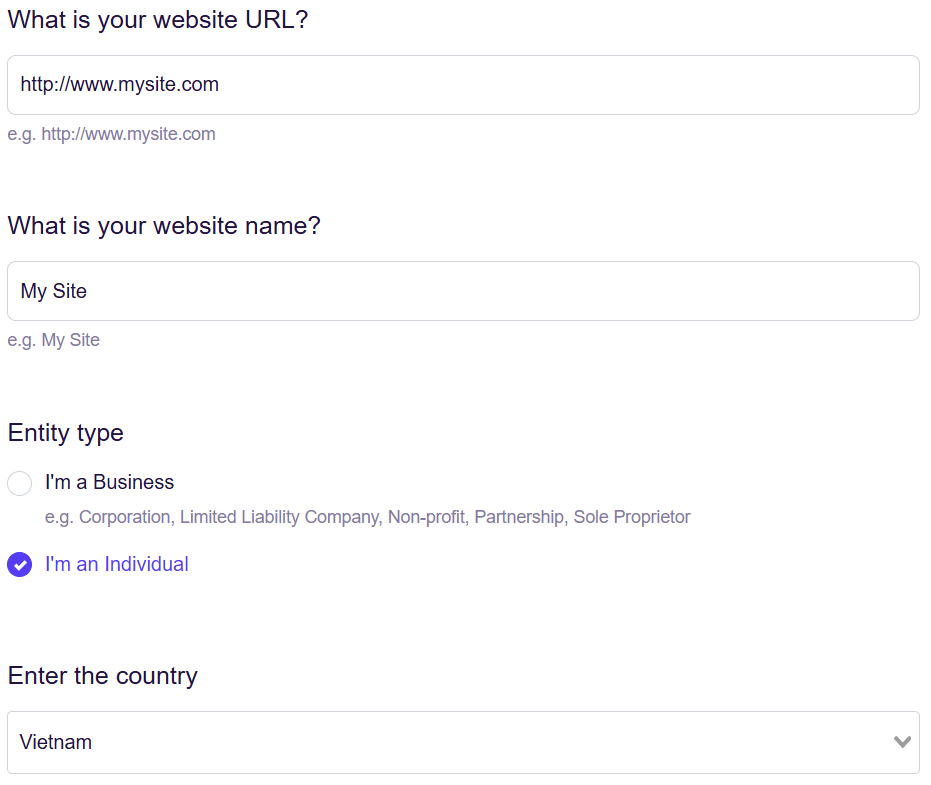
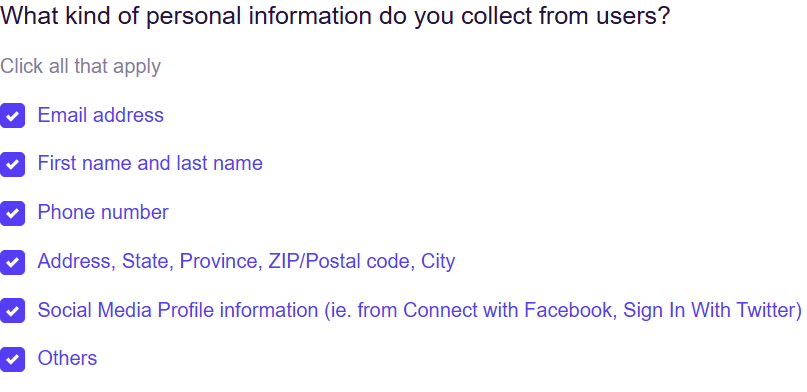

Result: https://www.freeprivacypolicy.com/live/f087f258-c2d4-432b-9ba2-6d7bd5325919

Paste the URL into Privacy Policy URL
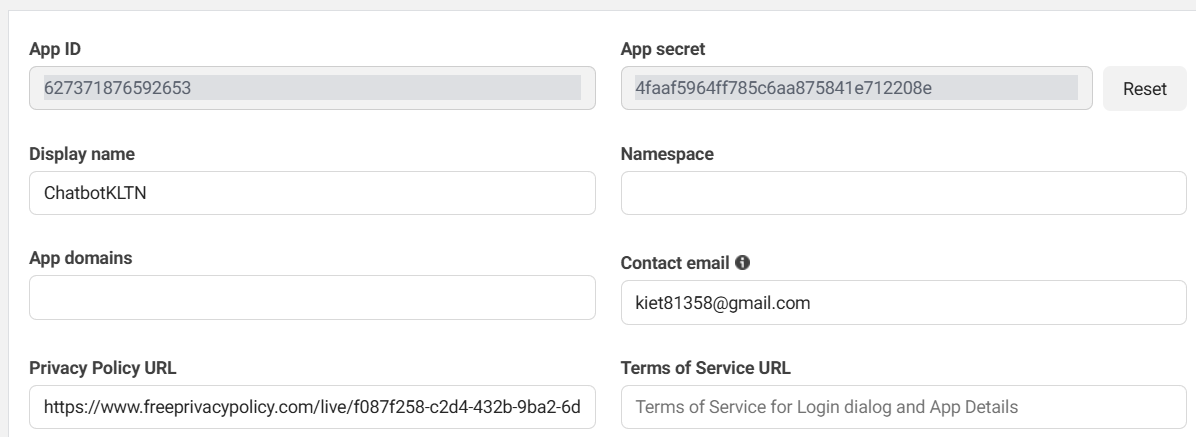
-> Turn into development 

Go to Dashboard -> Messenger ->SetUp -> Add or Remove Page -> Add page vừa tạo vào app
Sau đó tạo callback URL cho webhook
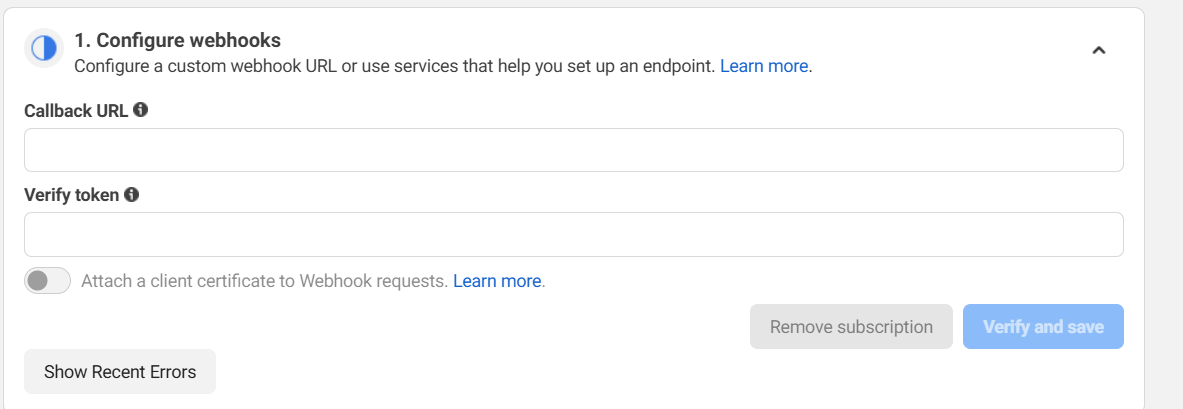

Setup webhook cho Messenger Platform

Get 
- FB_App_ID
- FB_App_Secret
- FB_Page_ID
- FB_Access_Token
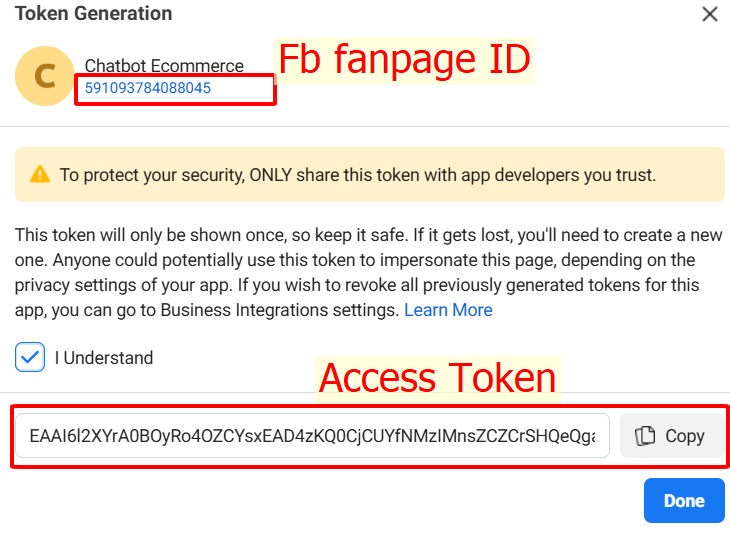
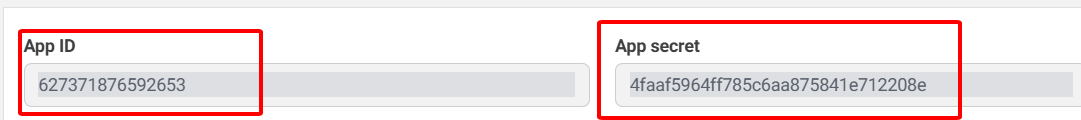

Tải ngrok trong wsl
https://ngrok.com/downloads/linux?tab=install

Run command
```bash
curl -sSL https://ngrok-agent.s3.amazonaws.com/ngrok.asc \
  | sudo tee /etc/apt/trusted.gpg.d/ngrok.asc >/dev/null \
  && echo "deb https://ngrok-agent.s3.amazonaws.com buster main" \
  | sudo tee /etc/apt/sources.list.d/ngrok.list \
  && sudo apt update \
  && sudo apt install ngrok
```
Add authtoken (Login gmail hoặc github)

`ngrok config add-authtoken 2TjZNRjSAURxfF46PrWEDssDVjO_9NaVJCHUGDEnXypRbgLc`

Chạy file messenger.py (run FastAPI app) `uvicorn messenger:app --reload`

Start an endpoint: `ngrok http 8000` (vì  Uvicorn running on http://127.0.0.1:8000 )

Lấy link ngrok https://4f2d-171-248-172-17.ngrok-free.app được tạo đưa lên Callback URL </br>
Verify token là token ta tự tạo để xác thực với fb app (ở đây ta lấy luôn FB Access Token) </br>

Fb Access Token generate từ (2) (Thêm tất cả các quyền subscription)
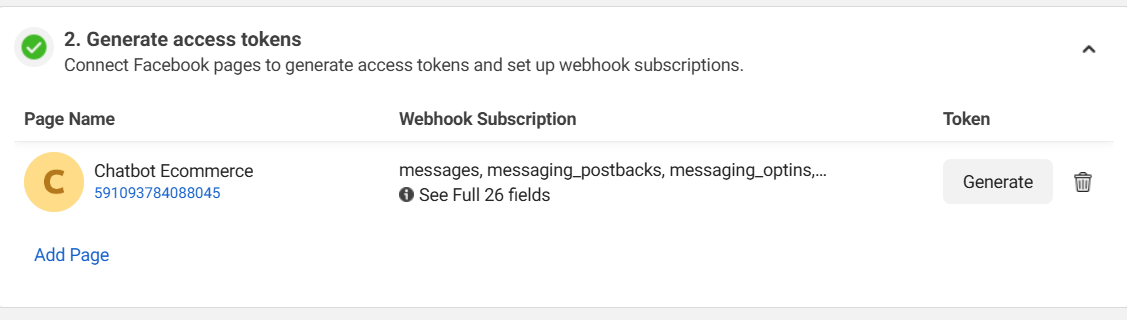
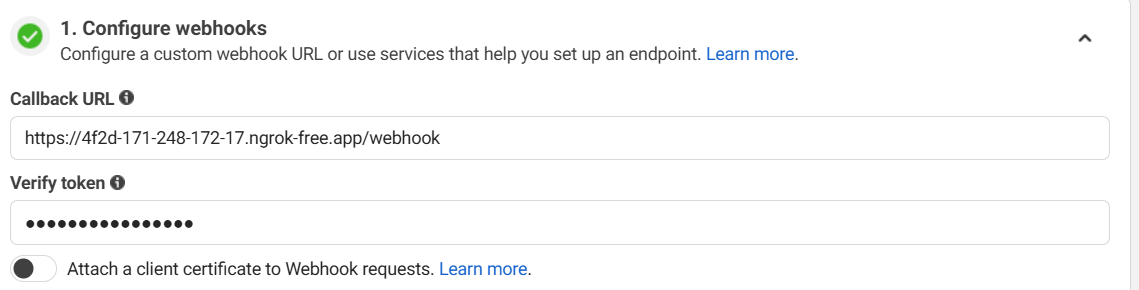
